## 2-Qubit Boltzmann Machine

In [7]:
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms

In [8]:
def expmat(A):
    """
    Computes the exponential of a given matrix `A'.
    """
    A = 0.5 * (A + np.transpose(np.conjugate(A)))
    evals, evecs = np.linalg.eigh(A)
    N = len(evals)
    res = np.zeros((N,N),np.complex64)
    for i in range(N):
        eigenvector = evecs[:,i]
        projector = np.outer(eigenvector,eigenvector.conj())
        res += np.exp(evals[i]) * projector
    return res

def logmat(A):
    """
    Computes the natural logarithm of a given matrix `A`.
    """
    A = 0.5 * (A + np.transpose(np.conjugate(A)))
    evals, evecs = np.linalg.eigh(A)
    N = len(evals)
    res = np.zeros((N,N),np.complex64)
    for i in range(N):
        eigenvector = evecs[:,i]
        projector = np.outer(eigenvector,eigenvector)
        res += np.log(evals[i]) * projector
    return res


def generate_interaction_matrices():
    """
    Constructs the tensor product of Pauli matrices for each spin and 
    uses them to build the interaction matrices between the two spins.
    """
    pauI = np.array([[1,0],[0,1]],np.complex64)
    pauX = np.array([[0,1],[1,0]],np.complex64)
    pauY = np.array([[0,-1j],[1j,0]],np.complex64)
    pauZ = np.array([[1,0],[0,-1]],np.complex64)
    pau = np.zeros((4,4,4),np.complex64)
    pau = np.array([pauI,pauX,pauY,pauZ])

    interactions = np.zeros((4,4,4,4),dtype = np.complex64)
    for k in range(4):
        for kprime in range(4):
            interactions[k,kprime] = np.kron(pau[k],pau[kprime])
    return interactions

def hamiltonian2spins(w,interactions):
    """
    Calculates the Hamiltonian matrix of a two-spin system 
    """
    H = np.zeros((4,4),np.complex64)
    for k in range(4):
        for kprime in range(4):
            H += w[k,kprime] * interactions[k,kprime]
    return H

def rho_model(w,interactions):
    """
    Computes the density matrix of a two-spin system using the Hamiltonian
    and the interaction matrices, and then normalizes it. Exact Diagonalization.
    """
    H      = hamiltonian2spins(w,interactions)        #  get hamiltonian matrix
    rho    = expmat(H)                                #  defintion of rho
    Z      = np.real(np.trace(rho))                   #  get Z
    rho   /= Z                                        #  normalize such that Tr[rho] = 1
    return rho

def generate_w_random(seed):
    rng    = np.random.default_rng(seed)      #  set random seed for reproduciblity
    w      = rng.normal(size=(4,4))           #  get normal distributed weights
    w[0,0] = 0
    return w

def generate_w(wx1x2 ,wy1y2, w1z2z, hx1, hx2, hy1, hy2, hz1, hz2):
    w = np.zeros((4,4))
    w[0,0] = 0
    w[1,1] = wx1x2
    w[2,2] = wy1y2
    w[3,3] = w1z2z
    w[1,0] = hx1
    w[0,1] = hx2
    w[2,0] = hy1
    w[0,2] = hy2
    w[3,0] = hz1
    w[0,3] = hz2
    return w


In [74]:
def discrete_time_dynamics(w,t_vals,interactions):
    """
    Get transition matrix from parameters; use it to update dyamics
    """
    s1_vals = np.zeros(len(t_vals))                     #  initialize values to store
    s2_vals = np.zeros(len(t_vals))    

    H = hamiltonian2spins(w, interactions)
    g_i = np.sum(expmat(H))           #NEED TO NORMALIZE THIS
    s1,s2 = 1, 1                      #initialize spins
    for i,t in enumerate(t_vals):
        if g_i < np.random.rand():
            s1 *= -1
        if g_i < np.random.rand():
            s2 *= -1
        
        s1_vals[i] = s1
        s2_vals[i] = s2

    return s1_vals, s2_vals

def generate_states(s1, s2, t_vals):
    states = np.zeros(len(t_vals))
    for i in range(len(t_vals)):
        if s1[i] == 1 and s2[i] == 1:
            states[i] = 0

        if s1[i] == 1 and s2[i] == -1:
            states[i] = 1

        if s1[i] == -1 and s2[i] == 1:
            states[i] = 2

        if s1[i] == -1 and s2[i] == -1:
            states[i] = 3
    return states
        

In [75]:
def plot_dynamics(s1, s2, t_vals):
    fig = plt.figure(figsize=(25, 6));                           #  make plots
    fig.suptitle("YOLO", fontsize=30, y = 1)
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)

    states = generate_states(s1,s2, t_vals)
    s1s2 = s1*s2


    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(t_vals,states)
    ax1.set_xlabel("time", fontsize=20)
    ax1.set_ylabel("states", fontsize=20)
    
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(t_vals,s1)
    ax2.plot(t_vals,s2)
    ax2.plot(t_vals,s1s2)
    ax2.set_xlabel("time", fontsize=20)
    ax2.set_ylabel("states", fontsize=20)

In [76]:
#PARAMETERS
dt = 0.01  #discrete time steps of simulation
sim_time = 2 #time simulation should run
t_vals = np.arange(0,sim_time,dt)

#interaction parameters
wx1x2 = 0
wy1y2 = 0
wz1z2 = 2
hx1   = 0
hx2   = 0
hy1   = 0
hy2   = 0
hz1   = 1
hz2   = 1
    
w = generate_w(wx1x2 ,wy1y2, wz1z2, hx1, hx2, hy1, hy2, hz1, hz2)
interactions = generate_interaction_matrices()

(55.868816+0j)


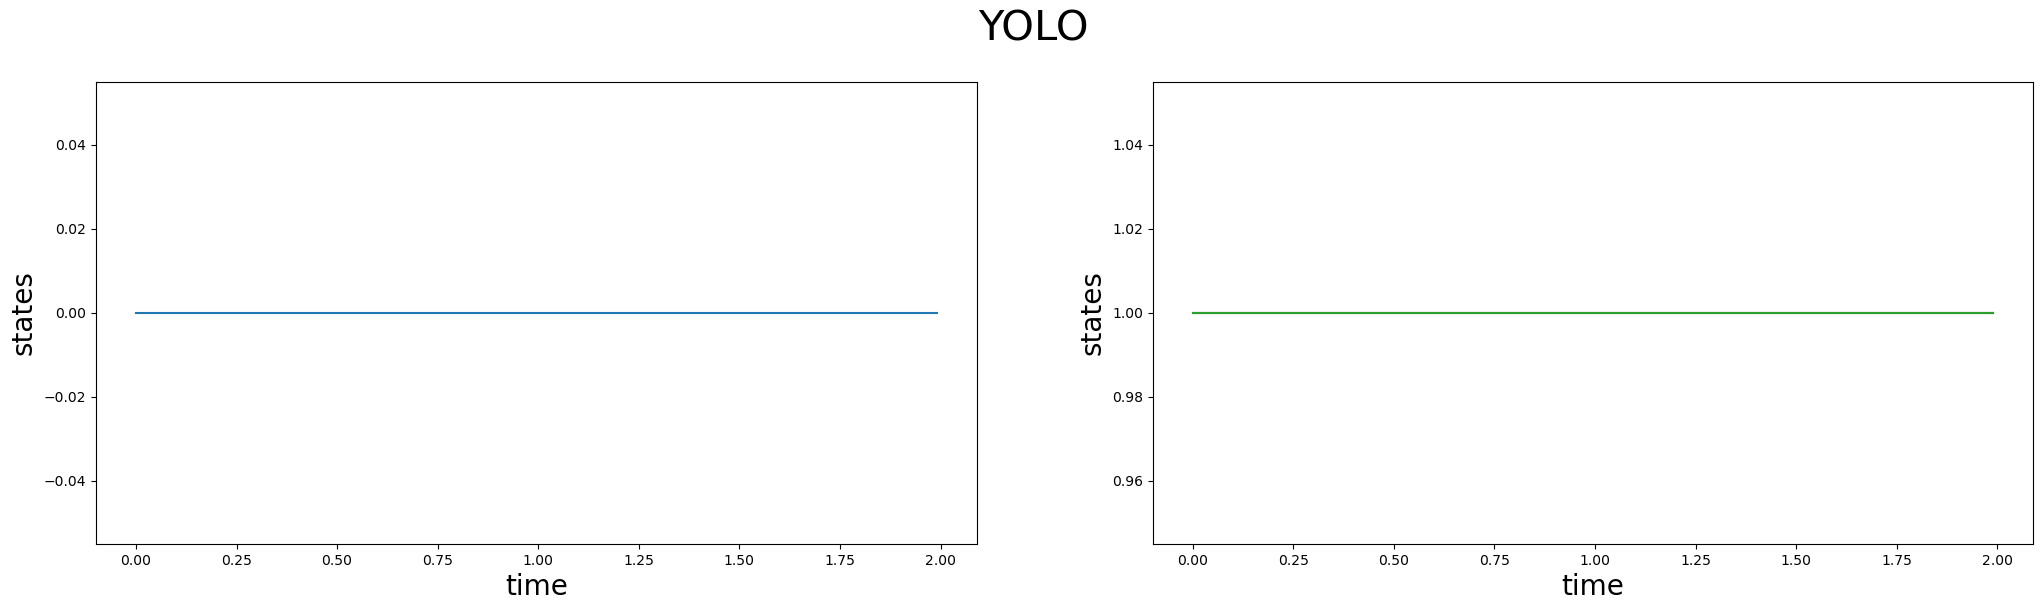

In [77]:
s1, s2 = discrete_time_dynamics(w, t_vals, interactions)
plot_dynamics(s1, s2, t_vals)